# LSTM base net Implemented by Keras

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

import tensorflow.keras as keras
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

import ipdb
import dan_utils

In [2]:
# 设置随机数种子
seed = 25
dan_utils.setup_seed(seed)

# Load data

In [3]:
flow_df = pd.read_csv('../data/revised_data/flow_y_revised.csv')
flow = flow_df.to_numpy()

In [4]:
flow.shape

(40, 4464)

# Data assembling

In [5]:
# # sliding window
# window_size = 10
# pred_size = 20
# train_X = np.zeros([flow.shape[0] - window_size - pred_size + 1, window_size, flow.shape[1]])
# train_y = np.zeros(train_X.shape[0], pred_size)

# for i in range(window_size):
#     train_X[:, i, :] += flow_df.shift(window_size - i - 1).iloc[window_size - 1:, :]
#     # train_y[:, i] += flow_df.shift(window_size - i - 1).iloc[window_size - 1:, :]


In [6]:
def sliding_window(data, window_size, pred_samp, prop):
    
#     data = data.flatten()
    data_out = []
    label_out = []
    for i in range(data.shape[1] - window_size - pred_samp):
        data_out.append(data[:, i : i + window_size])
        # to predict the next [window size] flows
        label_out.append(data[:, i + window_size + 1: i + window_size + 1 + pred_samp])
    data_out = np.array(data_out)
    label_out = np.array(label_out)
#     ipdb.set_trace()
    train_data_out = data_out[:int(data_out.shape[0]*prop), :]
    train_label_out = label_out[:int(data_out.shape[0]*prop)]
    val_data_out = data_out[int(data_out.shape[0]*prop):, :]
    val_label_out = label_out[int(data_out.shape[0]*prop):]
    
    train_data_out = np.transpose(train_data_out, [0, 2, 1])
    train_label_out = np.transpose(train_label_out, [0, 2, 1])
    val_data_out = np.transpose(val_data_out, [0, 2, 1])
    val_label_out = np.transpose(val_label_out, [0, 2, 1])
    
    return train_data_out, train_label_out, val_data_out, val_label_out


In [7]:
window_size = 10
pred_samp = 10

train_X, train_y, test_X, test_y = sliding_window(flow, window_size, pred_samp, 24/31)

In [8]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(3440, 10, 40)
(3440, 10, 40)
(1004, 10, 40)
(1004, 10, 40)


# LSTM network (base)

In [9]:
# data at the position of "number of detectors" are the same
assert train_X.shape[2] == train_y.shape[2]
assert train_X.shape[2] == test_X.shape[2]
assert train_X.shape[2] == test_y.shape[2]
num_det = flow.shape[0]

hid_dim = 40

In [10]:
train_X.shape

(3440, 10, 40)

In [11]:
model = keras.models.Sequential()
# out shape: [window_size, hid_dim]
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LSTM(units=hid_dim, return_sequences=True))
# model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
# model.add(keras.layers.Dense(64, activation='relu'))
# model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(num_det, activation='relu'))

# Training on target data

In [12]:
model.compile(loss='mse', optimizer='adam')
history = model.fit(train_X, train_y, epochs=400, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=True)

Epoch 1/400
27/27 - 4s - loss: 240087.5781 - val_loss: 242083.9219
Epoch 2/400
27/27 - 0s - loss: 239524.9375 - val_loss: 241058.8750
Epoch 3/400
27/27 - 0s - loss: 238796.0625 - val_loss: 240068.9062
Epoch 4/400
27/27 - 0s - loss: 237963.2031 - val_loss: 239103.9062
Epoch 5/400
27/27 - 0s - loss: 237073.8750 - val_loss: 238100.7500
Epoch 6/400
27/27 - 0s - loss: 236112.4219 - val_loss: 237175.2656
Epoch 7/400
27/27 - 0s - loss: 235043.0625 - val_loss: 235978.4375
Epoch 8/400
27/27 - 0s - loss: 233898.2031 - val_loss: 234848.2500
Epoch 9/400
27/27 - 0s - loss: 232639.8906 - val_loss: 233537.1094
Epoch 10/400
27/27 - 0s - loss: 231311.0938 - val_loss: 232234.4219
Epoch 11/400
27/27 - 0s - loss: 229868.3125 - val_loss: 230822.4531
Epoch 12/400
27/27 - 0s - loss: 228375.5156 - val_loss: 229328.5781
Epoch 13/400
27/27 - 0s - loss: 226779.2188 - val_loss: 227796.5781
Epoch 14/400
27/27 - 0s - loss: 225110.6719 - val_loss: 226315.7188
Epoch 15/400
27/27 - 0s - loss: 223367.1094 - val_loss: 2

Epoch 123/400
27/27 - 0s - loss: 91192.1875 - val_loss: 94479.4688
Epoch 124/400
27/27 - 0s - loss: 91215.9688 - val_loss: 94232.5078
Epoch 125/400
27/27 - 0s - loss: 90977.3125 - val_loss: 94386.0625
Epoch 126/400
27/27 - 0s - loss: 90836.7734 - val_loss: 94352.4453
Epoch 127/400
27/27 - 0s - loss: 91005.5469 - val_loss: 94194.5938
Epoch 128/400
27/27 - 0s - loss: 90983.1094 - val_loss: 94152.4375
Epoch 129/400
27/27 - 0s - loss: 91099.1016 - val_loss: 94091.6172
Epoch 130/400
27/27 - 0s - loss: 90738.4844 - val_loss: 94026.9297
Epoch 131/400
27/27 - 0s - loss: 90657.2500 - val_loss: 93971.1719
Epoch 132/400
27/27 - 0s - loss: 90614.4453 - val_loss: 94421.5234
Epoch 133/400
27/27 - 0s - loss: 90801.7891 - val_loss: 94076.6250
Epoch 134/400
27/27 - 0s - loss: 90525.9375 - val_loss: 93890.7891
Epoch 135/400
27/27 - 0s - loss: 90484.3594 - val_loss: 93874.2500
Epoch 136/400
27/27 - 0s - loss: 90433.3750 - val_loss: 93812.1953
Epoch 137/400
27/27 - 0s - loss: 90448.8672 - val_loss: 93806.

Epoch 246/400
27/27 - 0s - loss: 35587.5703 - val_loss: 32657.5742
Epoch 247/400
27/27 - 0s - loss: 33483.1758 - val_loss: 30497.1191
Epoch 248/400
27/27 - 0s - loss: 31067.8398 - val_loss: 27579.8145
Epoch 249/400
27/27 - 0s - loss: 28955.3086 - val_loss: 25738.1172
Epoch 250/400
27/27 - 0s - loss: 27270.3438 - val_loss: 24785.3652
Epoch 251/400
27/27 - 0s - loss: 25828.0840 - val_loss: 25227.3086
Epoch 252/400
27/27 - 0s - loss: 24705.6172 - val_loss: 22730.0586
Epoch 253/400
27/27 - 0s - loss: 23430.8945 - val_loss: 21869.9375
Epoch 254/400
27/27 - 0s - loss: 22306.1113 - val_loss: 21580.2324
Epoch 255/400
27/27 - 0s - loss: 21596.6875 - val_loss: 21530.3691
Epoch 256/400
27/27 - 0s - loss: 20574.9551 - val_loss: 19885.1133
Epoch 257/400
27/27 - 0s - loss: 19664.4551 - val_loss: 19555.0059
Epoch 258/400
27/27 - 0s - loss: 18839.0703 - val_loss: 18460.3359
Epoch 259/400
27/27 - 0s - loss: 18334.3320 - val_loss: 18133.5469
Epoch 260/400
27/27 - 0s - loss: 17595.8574 - val_loss: 17388.

Epoch 371/400
27/27 - 0s - loss: 4684.9331 - val_loss: 6343.1152
Epoch 372/400
27/27 - 0s - loss: 4674.0044 - val_loss: 6273.9346
Epoch 373/400
27/27 - 0s - loss: 4637.1260 - val_loss: 6037.9009
Epoch 374/400
27/27 - 0s - loss: 4946.1025 - val_loss: 6147.1758
Epoch 375/400
27/27 - 0s - loss: 4903.5889 - val_loss: 6260.7065
Epoch 376/400
27/27 - 0s - loss: 4564.4321 - val_loss: 6001.0356
Epoch 377/400
27/27 - 0s - loss: 4554.7490 - val_loss: 6029.1221
Epoch 378/400
27/27 - 0s - loss: 4481.5459 - val_loss: 6077.0615
Epoch 379/400
27/27 - 0s - loss: 4589.6196 - val_loss: 6047.7012
Epoch 380/400
27/27 - 0s - loss: 4473.5215 - val_loss: 5914.4385
Epoch 381/400
27/27 - 0s - loss: 4639.1304 - val_loss: 6104.5078
Epoch 382/400
27/27 - 0s - loss: 4750.6958 - val_loss: 5896.2544
Epoch 383/400
27/27 - 0s - loss: 4603.9761 - val_loss: 6145.5552
Epoch 384/400
27/27 - 0s - loss: 4803.1826 - val_loss: 6472.8525
Epoch 385/400
27/27 - 0s - loss: 4830.3999 - val_loss: 7087.1455
Epoch 386/400
27/27 - 0s 

# Visualization

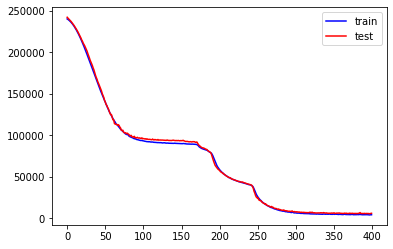

In [13]:
p1 = plt.plot(history.history['loss'], color='blue', label='train')
p2 = plt.plot(history.history['val_loss'], color='red',label='test')
plt.legend()

In [14]:
yhat = model.predict(test_X)

In [15]:
test_y.shape

(1004, 10, 40)

Text(0.5, 1.0, 'Testing dataset')

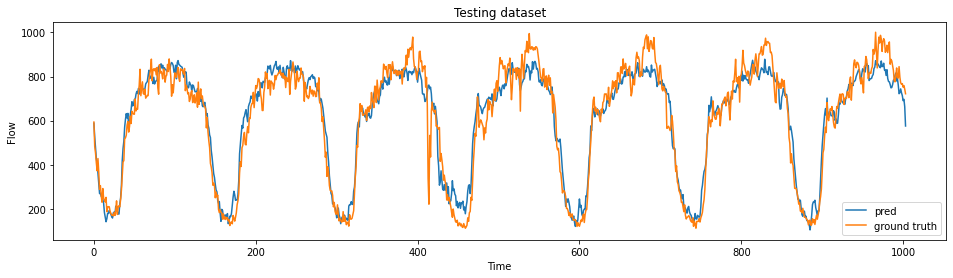

In [16]:
n_step_ahead = 3
det = 0

plt.figure(figsize=[16,4])
plt.plot(yhat[:, n_step_ahead, det], label='pred')
plt.plot(test_y[:, n_step_ahead, det], label='ground truth')
plt.legend()
plt.xlabel('Time')  # time gran: 15 min
plt.ylabel('Flow')
plt.title('Testing dataset')

# Evaluation

In [17]:
#transfer with DAN 预测精度计算
m=0
model_pre = yhat
label_test_target = test_y

nrmse_mean = dan_utils.nrmse_loss_func(model_pre, label_test_target, m)
mape_mean = dan_utils.mape_loss_func(model_pre, label_test_target, m)
smape_mean = dan_utils.smape_loss_func(model_pre, label_test_target, m)
mae_mean = dan_utils.mae_loss_func(model_pre, label_test_target, m)

print('nrmse = ' + str(nrmse_mean) + '\n' + 'mape = ' + str(mape_mean) + '\n' + 'smape = ' + str(smape_mean) + '\n' + 'mae = ' + str(mae_mean))

nrmse = 0.16025463712389162
mape = 0.2517831192561929
smape = 0.09344239382402358
mae = 57.12998471100682
